# Analyze RAGIS ensmbles

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os

import seaborn as sns

from pismragis.observations import load_imbie, load_imbie_csv, load_mouginot
from pismragis.analysis import resample_ensemble_by_data, sensitivity_analysis
from pismragis.processing import convert_netcdf_to_dataframe, check_file, copy_file
from pismragis.stats import run_stats

In [2]:
n_jobs = 4
norm_year = 1992

plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "D (Gt/yr)"
discharge_uncertainty_varname = "D uncertainty (Gt/yr)"
smb_varname = "SMB (Gt/yr)"
smb_uncertainty_varname = "SMB uncertainty (Gt/yr)"


bg_color = "#216779"
bg_color = "w"
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]

sim_colors = [ "#d73027", "#fc8d59", "#4575b4", "#91bfdb", "#fee090"]

imbie_color = "#756bb1"
mou_color = "#54278f"

imbie_color = "0.4"
mou_color = "0.2"

    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2

## Load Observations

In [3]:
# imbie = load_imbie(url="../imbie_dataset_greenland_dynamics-2020_02_28.xlsx")
imbie = load_imbie()
# Glacier and Ice cap bias 30 Gt/yr, add it back
# imbie[mass_varname] -= 30 * gt2cmsle
#imbie[smb_varname] += 30

mou = load_mouginot(url="/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx")
mou_gis = mou[mou["Basin"] == "GIS"]

## Make a list of all experiments

In [4]:
data_dir = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism"

exps = []

exps.append({
    "Experiment": "GIMP",
    "proj_dir": "2023_08_gimp_tw_25",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_lhs_25",
    "DEM": "GIMP"
}
)


exps.append({
    "Experiment": "GIMP w/post",
    "proj_dir": "2023_08_gimp_tw_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "GIMP"
}
)

exps.append({
    "Experiment": "RAGIS",
    "proj_dir": "2023_08_ragis_tw_25",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_lhs_25",
    "DEM": "RAGIS"
}
)

exps.append({
    "Experiment": "RAGIS w/post",
    "proj_dir": "2023_08_ragis_tw_50",
    "scalar_dir": "scalar",
    "processed_dir": "processed",
    "lhs": "gris_ragis_ocean_calving_w_posterior_lhs_50",
    "DEM": "RAGIS"
}
)


## Process experiments

In [10]:
experiments = []

for exp in exps:
    print(f"""Processing {exp["Experiment"]}""")
    print("================================================\n")
    ens_file = os.path.join(data_dir, exp["proj_dir"], "uq", f"""{exp["lhs"]}.csv""")
    s_dir = os.path.join(data_dir, exp["proj_dir"], exp["scalar_dir"])
    scalar_files = sorted(glob(os.path.join(s_dir, f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc""")))
    processed_path = os.path.join(data_dir, exp["proj_dir"], exp["processed_dir"])
    for scalar_file in scalar_files:
        if check_file(scalar_file):
            copy_file(scalar_file, processed_path)
        
    processed_files = sorted(glob(os.path.join(processed_path, f"""ts_gris_g*00m_*{exp["DEM"]}_id_*_1980-1-1_2020-1-1.nc""")))
    exp_df = convert_netcdf_to_dataframe(processed_files, resample="yearly", verbose=False, n_jobs=n_jobs)
    exp_df["Experiment"] = exp["Experiment"]
    exp["data_df"] = exp_df
    exp["run_stats"] = run_stats(processed_files, experiment=exp["Experiment"])
    try:
        sa_df = sensitivity_analysis(exp_df.dropna(), ensemble_file=ens_file, n_jobs=n_jobs)
        exp["sensitivity_df"] = sa_df
    except:
        pass
    experiments.append(exp)


Processing GIMP

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_gimp_tw_25/scalar/ts_gris_g900m_v2023_GIMP_id_10_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_gimp_tw_25/scalar/ts_gris_g900m_v2023_GIMP_id_12_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_gimp_tw_25/scalar/ts_gris_g900m_v2023_GIMP_id_13_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_gimp_tw_25/scalar/ts_gris_g900m_v2023_GIMP_id_14_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_gimp_tw_25/scalar/ts_gris_g900m_v2023_GIMP_id_15_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Driv

Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.39it/s]


Conversion finished in 6 seconds
-------------------------------------------
-------------------------------------------

Processing GIMP w/post

Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  3.98it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS

/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_ragis_tw_25/scalar/ts_gris_g900m_v2023_RAGIS_id_13_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pism/2023_08_ragis_tw_25/scalar/ts_gris_g900m_v2023_RAGIS_id_14_1980-1-1_2020-1-1.nc time-series too short or not monotonically-increasing.
Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.26it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------

Processing RAGIS w/post

Converting netcdf files to pandas.DataFrame
-------------------------------------------


Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.34it/s]


Conversion finished in 2 seconds
-------------------------------------------
-------------------------------------------



Peformace Summary for Experiment GIMP (9 members)
---------------------------------------------------

processor_hours                   21406.153357
wall_clock_hours                    178.384611
model_years_per_processor_hour        0.015054
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment GIMP w/post (7 members)
---------------------------------------------------

processor_hours                   23326.718890
wall_clock_hours                    194.389324
model_years_per_processor_hour        0.011794
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS (13 members)
---------------------------------------------------

processor_hours                   20229.150121
wall_clock_hours                    168.576251
model_years_per_processor_hour        0.018990
dtype: float64
---------------------------------------------------

Peformace Summary for Experiment RAGIS w/post (6 member

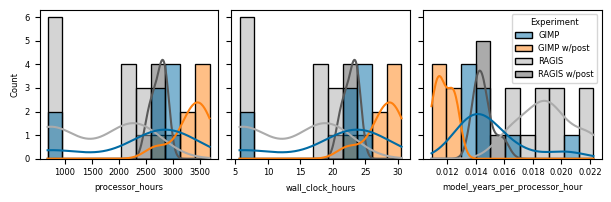

In [11]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

e = experiments[0]["run_stats"]
m_vars = ["processor_hours", "wall_clock_hours", "model_years_per_processor_hour"]
for m in range(len(experiments)):
    e_df = experiments[m]["run_stats"]
    print(f"""Peformace Summary for Experiment {experiments[m]["Experiment"]} ({len(e_df)} members)""")
    print("---------------------------------------------------\n")
    print(e_df.agg({'processor_hours': 'sum', 'wall_clock_hours': "sum", "model_years_per_processor_hour": "mean"}))
    print("---------------------------------------------------\n")

fig, axs = plt.subplots(nrows=1, ncols=len(m_vars), sharey="row", figsize=[6.2, 2.0])
fig.subplots_adjust(wspace=0)


all_run_stats = pd.concat([experiments[k]["run_stats"] for k in range(len(experiments))]).reset_index(drop=True)
[sns.histplot(data=all_run_stats, x=m_var, bins=11, kde=True, hue="Experiment", ax=axs[k]) for k, m_var in enumerate(m_vars)]
axs[0].legend([], [], frameon=False)
axs[1].legend([], [], frameon=False)


fig.tight_layout()
fig.savefig("run_stats.pdf")
!open run_stats.pdf

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

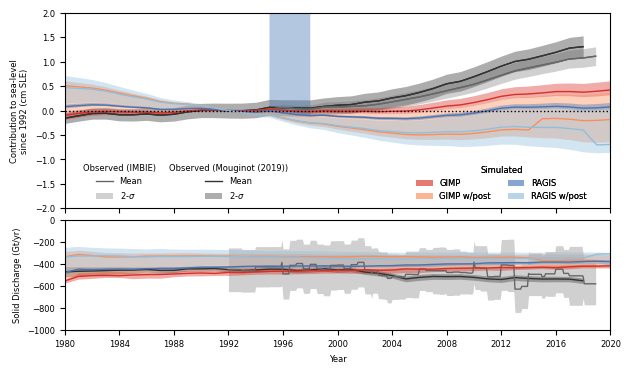

In [13]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(6.2, 3.6), height_ratios=[16, 9])
fig.subplots_adjust(wspace=0, hspace=0.075, bottom=0.1, top=0.98, left=0.1, right=0.98)


for obs, o, obs_color, obs_loc, obs_alpha  in zip([mou_gis, imbie], ["Mouginot (2019)", "IMBIE"], 
                                       [mou_color, imbie_color], [(0.3, 0.0), (0.1, 0.0)], [0.4, 0.3]):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    obs_line = axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[1].plot(obs["Date"], obs[discharge_varname], color=obs_color, lw=1)

    legend_obs = axs[0].legend(handles=[obs_line[0], obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title=f"Observed ({o})")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.4, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.4, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.8, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-2, 2)
axs[1].set_ylim(-1000, 0)

# fig.tight_layout()
fig.savefig("ragis-comp_scalar.pdf")
!open ragis-comp_scalar.pdf

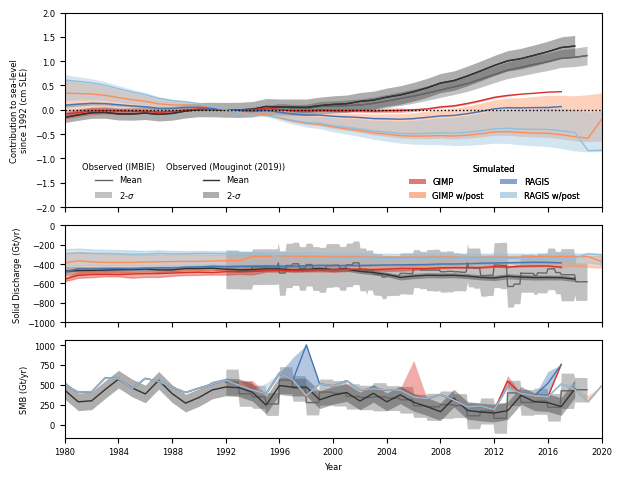

In [106]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")

fig, axs = plt.subplots(nrows=3, ncols=1, sharex="col", figsize=(6.2, 4.8), height_ratios=[2, 1, 1])
fig.subplots_adjust(wspace=0, hspace=0)


for obs, o, obs_color, obs_loc, obs_alpha  in reverse(zip([imbie, mou_gis], ["IMBIE", "Mouginot (2019)"], 
                                       [imbie_color, mou_color], [(0.1, 0.0), (0.3, 0.0)], [0.4, 0.4])):
    obs_ci = axs[0].fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha, label=f"{sigma}-$\sigma$")
    axs[1].fill_between(obs["Date"], 
                    (obs[discharge_varname] + sigma * obs[discharge_uncertainty_varname]), 
                    (obs[discharge_varname] - sigma * obs[discharge_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    axs[2].fill_between(obs["Date"], 
                    (obs[smb_varname] + sigma * obs[smb_uncertainty_varname]), 
                    (obs[smb_varname] - sigma * obs[smb_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=obs_alpha)
    obs_line = axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[0].plot(obs["Date"], obs[mass_varname], color=obs_color, lw=1, label="Mean")
    axs[1].plot(obs["Date"], obs[discharge_varname], color=obs_color, lw=1)
    axs[2].plot(obs["Date"], obs[smb_varname], color=obs_color, lw=1)

    legend_obs = axs[0].legend(handles=[obs_line[0], obs_ci], loc="lower center", bbox_to_anchor=obs_loc, 
                               title=f"Observed ({o})")
    legend_obs.get_frame().set_linewidth(0.0)
    legend_obs.get_frame().set_alpha(0.0)
    axs[0].add_artist(legend_obs)


sims_cis = []
sims_lines = []
for k, exp in enumerate(experiments):
    df = exp["data_df"]
    q_05 = df.groupby(by="time").quantile(0.05, numeric_only=True)
    q_50 = df.groupby(by="time").quantile(0.50, numeric_only=True)
    q_95 = df.groupby(by="time").quantile(0.95, numeric_only=True)
    sims_line = axs[0].plot(q_50.index, q_50[mass_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[1].plot(q_50.index, q_50[discharge_varname], color=sim_colors[k], alpha=1.0, lw=1)
    axs[2].plot(q_50.index, q_50[smb_varname], color=sim_colors[k], alpha=1.0, lw=1)
    sims_ci = axs[0].fill_between(q_05.index, q_05[mass_varname], 
                        q_95[mass_varname], color=sim_colors[k], alpha=0.4, lw=0, label=exp["Experiment"])
    axs[1].fill_between(q_05.index, q_05[discharge_varname], 
                        q_95[discharge_varname], color=sim_colors[k], alpha=0.4, lw=0)
    axs[2].fill_between(q_05.index, q_05[smb_varname], 
                        q_95[smb_varname], color=sim_colors[k], alpha=0.4, lw=0)
    sims_cis.append(sims_ci)
    sims_lines.append(sims_line[0])

if len(sims_cis) < 4:
    ncols = 1
else:
    ncols = 2
legend_sims = axs[0].legend(handles=sims_cis, loc="lower center", bbox_to_anchor=[0.8, .0], 
                           title=f"Simulated", ncols=ncols)
legend_sims.get_frame().set_linewidth(0.0)
legend_sims.get_frame().set_alpha(0.0)
axs[0].add_artist(legend_sims)
    



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

axs[0].axhline(0, color="k", ls="dotted", lw=1.0)
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level\nsince 1992 (cm SLE)")
axs[-1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[2].set_ylabel("SMB (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-2, 2)
axs[1].set_ylim(-1000, 0)
#axs[1].set_ylim(-1000, 100)

fig.tight_layout()
fig.savefig("ragis-comp_scalar-3.pdf")
!open ragis-comp_scalar-3.pdf

## Plot sensitivity index

In [107]:
plt.rc('font', size=6)
plt.style.use("tableau-colorblind10")


for e in experiments:
    sa_df = e["sensitivity_df"]
    si = "S1"
    outfile = f"""{e["lhs"]}.pdf"""
    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[6.2, 3.8],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=1, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.75))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


KeyError: 'sensitivity_df'

In [ ]:
m_e = experiments[0]["data_df"]
ragis_calib, weights = resample_ensemble_by_data(imbie, m_e, 
                                        fudge_factor=3, verbose=True)
calib_exps = ragis_calib["id"].unique()
print(calib_exps)

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05, numeric_only=True)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16, numeric_only=True)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50, numeric_only=True)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84, numeric_only=True)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95, numeric_only=True)
for exp in m_e:
    print(exp)
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], color="k", lw=1)
    print(e)
    axs[1].plot(e["Year"], e[discharge_varname], color="k", lw=1)

for exp in calib_exps:
    e = m_e[m_e["id"] == exp]
    axs[0].plot(e["Year"], e[mass_varname], lw=1)
    axs[1].plot(e["Year"], e[discharge_varname], lw=1)

axs[0].fill_between(q_50.index, q_16[mass_varname], q_84[mass_varname], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie[mass_varname] + sigma * imbie[mass_uncertainty_varname]), 
                    (imbie[mass_varname] - sigma * imbie[mass_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie[discharge_varname] + sigma * imbie[discharge_uncertainty_varname]), 
                    (imbie[discharge_varname] - sigma * imbie[discharge_uncertainty_varname]), 
                    ls="solid", lw=0, alpha=0.35, color=imbie_color)


axs[0].set_xlim(1992, 2020)
axs[0].set_ylim(0, 2)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
from scipy.interpolate import interp1d
from tqdm import tqdm


In [ ]:
np.array([  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351]
[  634.45744104  -235.12952599 -1167.45917464  -531.87414125
  -904.57676904    91.04033758   722.82730577   114.16742036
   423.55949261   625.02532308  -293.90580578   647.25631402
  -586.31879794 -1381.01064481   349.68201297   716.26847793
   363.33248697 -1011.23876497   -48.85983816   406.46475582
   605.17371227  -949.29602232  -988.06082517  -534.95763144
   405.57114816  -986.00865133  -649.38528098   665.06762932
   625.46368323   385.91494928 -1067.25259603  1053.83389006
   230.25552736  -390.24453682   176.72057353 -1066.75620664
  -303.09711807   312.49178881   942.86270865   783.1536109
   111.79503873  -139.82581505   570.4991376   -757.75426472
   586.62399324    39.56232318   879.51778518   524.42354351])

In [ ]:
np.exp(weights)

In [ ]:
imbie

In [ ]:
e

In [ ]:
calib_exps

In [ ]:
e

In [ ]:
m_e

In [ ]:
experiments[1]["data_df"]

In [ ]:
m_e = experiments[2]["data_df"]

In [ ]:
m_e

In [ ]:
def resample_ensemble_by_data_o(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(
            observed_calib_period["Year"],
            observed_calib_period[m_var],
            observed_calib_period[m_var_std],
        ):
            try:
                observed_std *= fudge_factor
                exp_mean = exp_interp(year)

                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled


In [ ]:
def resample_ensemble_by_data(
    observed: pd.DataFrame,
    simulated: pd.DataFrame,
    id_var: str = "id",
    calibration_start: float = 1992.0,
    calibration_end: float = 2017.0,
    fudge_factor: float = 3,
    n_samples: int = 100,
    verbose: bool = False,
    m_var: str = "Mass (Gt)",
    m_var_std: str = "Mass uncertainty (Gt)",
) -> pd.DataFrame:
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period[id_var].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[(simulated_calib_period[id_var] == i)]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, exp_mean in zip(exp_["Year"], exp_[m_var]):
            try:
                observed_mean = observed_interp_mean(year)
                observed_std = observed_interp_std(year) * fudge_factor
                log_like -= 0.5 * (
                    (exp_mean - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                print(i, year, f"{observed_mean:.3f}", f"{observed_std:.3f}", f"{exp_mean:.3f}")

            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(simulated[(simulated[id_var] == i)])
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled, weights

In [ ]:
import xarray as xr

In [ ]:
xr.open_dataset("../../pism-emulator/pddemulator/DMI-HIRHAM5_1980_2020_MMS.nc")

In [ ]:
exp_df

In [ ]:
experiments[0].items()

In [ ]:
uq_df = pd.read_csv("../uq/gris_ragis_calving_simple_lhs_50.csv")

In [ ]:
uq_df.hist()

In [ ]:
mou

In [ ]:
    url = "/Users/andy/Google Drive/My Drive/Projects/RAGIS/data/pnas.1904242116.sd02.xlsx"
    norm_year = 1992.0


In [ ]:
dfs = []
for basin, idx in zip(["GIS", "SE", "CE", "NE", "NW", "CW", "SW"], 
                      [[7, 19, 29, 41], 
                       [6, 18, 28, 40], 
                       [5, 17, 27, 39], 
                       [4, 16, 26, 38],
                       [3, 15, 25, 37],
                       [2, 14, 24, 36],
                       [1, 13, 23, 35]]):
    
    df_m = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,P:BJ",
        engine="openpyxl",
    )

    d = df_m.iloc[idx[0]]
    smb = df_m.iloc[idx[1]]
    mass = df_m.iloc[idx[3]]

    df_u = pd.read_excel(
        url,
        sheet_name="(2) MB_GIS",
        header=8,
        usecols="B,CE:DY",
        engine="openpyxl",
    )
    d_u = df_u.iloc[idx[0]]
    smb_u = df_u.iloc[idx[1]]
    mass_u = df_u.iloc[idx[2]]
    mass_uc = df_u.iloc[idx[3]]

    df = pd.DataFrame(
        data=np.hstack(
            [
                df_m.columns[1::].values.reshape(-1, 1),
                mass.values[1::].reshape(-1, 1),
                smb.values[1::].reshape(-1, 1),
                -d.values[1::].reshape(-1, 1),
                mass_uc.values[1::].reshape(-1, 1),
                smb_u.values[1::].reshape(-1, 1),
                d_u.values[1::].reshape(-1, 1),
            ]
        ),
        columns=[
            "Year",
            "Mass (Gt)",
            "SMB (Gt/yr)",
            "D (Gt/yr)",
            "Mass uncertainty (Gt)",
            "SMB uncertainty (Gt/yr)",
            "D uncertainty (Gt/yr)",
        ],
    )
    df = df.astype(
        {
            "Year": float,
            "Mass (Gt)": float,
            "Mass uncertainty (Gt)": float,
            "SMB (Gt/yr)": float,
            "SMB uncertainty (Gt/yr)": float,
            "D (Gt/yr)": float,
            "D uncertainty (Gt/yr)": float,
        }
    )

    df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")

    # Normalize
    for v in [
        "Mass (Gt)",
    ]:
        df[v] -= df[df["Year"] == norm_year][v].values

    cmSLE = 1.0 / 362.5 / 10.0
    df["SLE (cm)"] = -df["Mass (Gt)"] * cmSLE
    df["SLE uncertainty (cm)"] = -df["Mass uncertainty (Gt)"] * cmSLE
    df["Basin"] = basin
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

In [ ]:
df["Mass (Gt)"]

In [ ]:
df[df["Basin"] == "SE"]

In [ ]:
df

In [89]:
plt.subplots_adjust?